# Data Preprocessing Pipeline - GitHub Repositories

This notebook handles:
- **Feature selection** (most relevant features for recommendations)
- **Language balancing** (percentage-based filtering & equity)
- **Text preprocessing** (cleaning, normalization)
- **Topics standardization** (format consistency)
- **Data quality improvements** (missing values, outliers)


In [2]:
# Load data from database
import sys
sys.path.append('../src')

from infrastructure.postgres.database import SessionLocal
from domain.models.schema import Project

# Load all projects
db = SessionLocal()
try:
    projects = db.query(Project).all()
    print(f"Loaded {len(projects)} projects from database")
finally:
    db.close()

import pandas as pd

# Convert to DataFrame
df = pd.DataFrame([{
    'id': p.id,
    'title': p.title,
    'description': p.description,
    'readme': p.readme,
    'language': p.language,
    'topics': p.topics,
    'html_url': p.html_url,
    'stargazers_count': p.stargazers_count,
    'forks_count': p.forks_count,
    'open_issues_count': p.open_issues_count,
    'pushed_at': p.pushed_at
} for p in projects])

print(f"Original dataset shape: {df.shape}")
df.head()


Loaded 494 projects from database
Original dataset shape: (494, 11)


,id,title,description,readme,language,topics,html_url,stargazers_count,forks_count,open_issues_count,pushed_at
0,7440612b-7c1b-4514-993f-9ac73366979b,MaxRobinsonTheGreat/LifeEngine,The Life Engine,"This is the readme for my evolution simulator,...",JavaScript,"simulation,evolutionary-algorithms",https://github.com/MaxRobinsonTheGreat/LifeEngine,500,121,20,2024-09-08 23:27:51+00:00
1,6c2b5dad-6fd2-4461-a988-b31cb98397ea,lodash/lodash,A modern JavaScript utility library delivering...,# lodash v4.17.21\n\n[Site](https://lodash.com...,JavaScript,"lodash,utilities,javascript,modules",https://github.com/lodash/lodash,60724,7064,114,2024-12-12 22:27:04+00:00
2,c7683120-345b-466a-bcda-2d9e2446c173,awolfly9/IPProxyTool,python ip proxy tool scrapy crawl. 抓取大量免费代理 i...,# IPProxyTool\n使用 scrapy 爬虫抓取代理网站，获取大量的免费代理 ip...,Python,"proxy,python,ipproxy",https://github.com/awolfly9/IPProxyTool,1994,416,12,2022-12-08 07:42:07+00:00
3,03cddb99-5d46-47bf-9132-0ca82adb9702,jesolem/PCV,Open source Python module for computer vision,## About PCV\nPCV is a pure Python library for...,Python,,https://github.com/jesolem/PCV,1946,679,27,2020-12-28 00:44:46+00:00
4,3200945d-d14e-4b84-b15b-1210f963b783,trycua/cua,c/ua is the Docker Container for Computer-Use ...,"<div align=""center"">\n <picture>\n <source...",Python,"apple,cua,lume,macos,virtualization,virtualiza...",https://github.com/trycua/cua,8941,404,58,2025-07-09 23:53:08+00:00


## 1. Language Balancing & Filtering


Language Distribution:
language
Python        17.206478
TypeScript    17.004049
JavaScript    16.801619
Go            15.789474
Rust          14.979757
Java          14.574899
C              0.607287
C++            0.404858
Swift          0.202429
Julia          0.202429
Name: count, dtype: float64

Languages to keep (>=5.0%): 6
['Python', 'TypeScript', 'JavaScript', 'Go', 'Rust', 'Java']

After language filtering: 476 repos (96.4% of original)


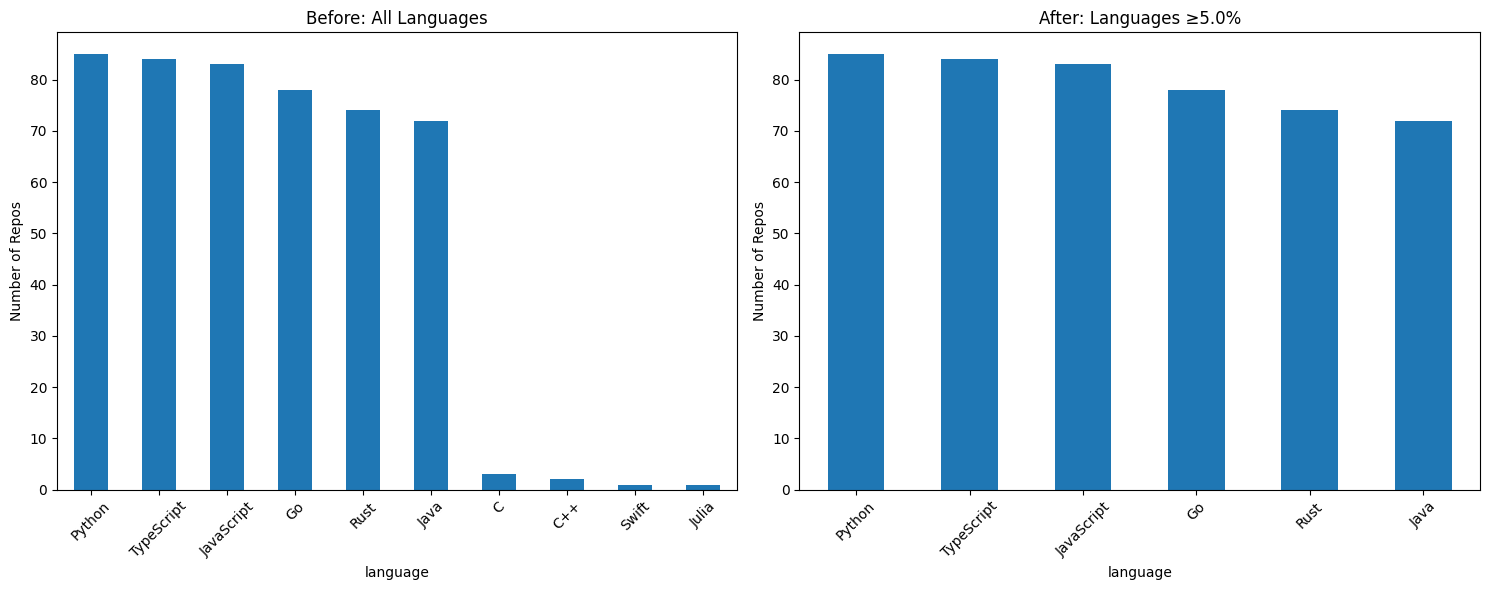

In [4]:
import matplotlib.pyplot as plt

# Language distribution analysis
language_counts = df['language'].value_counts()
language_percentages = (language_counts / len(df)) * 100

print("Language Distribution:")
print(language_percentages.head(10))

# Filter: Remove languages with <5% representation
MIN_LANGUAGE_PERCENT = 5.0
languages_to_keep = language_percentages[language_percentages >= MIN_LANGUAGE_PERCENT].index.tolist()

print(f"\nLanguages to keep (>={MIN_LANGUAGE_PERCENT}%): {len(languages_to_keep)}")
print(languages_to_keep)

# Apply filtering
df_filtered = df[df['language'].isin(languages_to_keep)].copy()
print(f"\nAfter language filtering: {len(df_filtered)} repos ({len(df_filtered)/len(df)*100:.1f}% of original)")

# Visualize before/after
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before filtering
language_counts.head(10).plot(kind='bar', ax=ax1)
ax1.set_title('Before: All Languages')
ax1.set_ylabel('Number of Repos')
ax1.tick_params(axis='x', rotation=45)

# After filtering
df_filtered['language'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title(f'After: Languages ≥{MIN_LANGUAGE_PERCENT}%')
ax2.set_ylabel('Number of Repos')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# Language equity balancing
# Balance top languages to prevent dominance
TARGET_SAMPLES_PER_LANGUAGE = 80  # Adjust based on your needs

balanced_dfs = []
for lang in languages_to_keep:
    lang_df = df_filtered[df_filtered['language'] == lang]
    
    # Sample up to TARGET_SAMPLES_PER_LANGUAGE
    if len(lang_df) > TARGET_SAMPLES_PER_LANGUAGE:
        lang_df = lang_df.sample(n=TARGET_SAMPLES_PER_LANGUAGE, random_state=42)
    
    balanced_dfs.append(lang_df)
    print(f"{lang}: {len(lang_df)} repos")

# Combine balanced datasets
df_balanced = pd.concat(balanced_dfs, ignore_index=True)
print(f"\nFinal balanced dataset: {len(df_balanced)} repos")

# Verify balance
print("\nFinal language distribution:")
print(df_balanced['language'].value_counts())


In [ ]:
# Feature importance analysis
print("=== FEATURE SELECTION ===")
print()

# Text features (for TF-IDF)
text_features = ['title', 'description', 'readme']
print("TEXT FEATURES:")
for feature in text_features:
    non_empty = df_balanced[feature].notna().sum()
    coverage = (non_empty / len(df_balanced)) * 100
    avg_length = df_balanced[feature].dropna().str.len().mean()
    print(f"  {feature}: {coverage:.1f}% coverage, avg {avg_length:.0f} chars")

print()

# Categorical features
categorical_features = ['language', 'topics']
print("CATEGORICAL FEATURES:")
for feature in categorical_features:
    unique_count = df_balanced[feature].nunique()
    coverage = (df_balanced[feature].notna().sum() / len(df_balanced)) * 100
    print(f"  {feature}: {unique_count} unique values, {coverage:.1f}% coverage")

print()

# Numerical features
numerical_features = ['stargazers_count', 'forks_count', 'open_issues_count']
print("NUMERICAL FEATURES:")
for feature in numerical_features:
    mean_val = df_balanced[feature].mean()
    median_val = df_balanced[feature].median()
    print(f"  {feature}: mean={mean_val:.1f}, median={median_val:.1f}")

print()

# Feature selection decision
selected_features = {
    'text': ['title', 'description'],  # Skip readme if too sparse
    'categorical': ['language', 'topics'],
    'numerical': ['stargazers_count', 'open_issues_count']  # Skip forks_count if correlated
}

print("SELECTED FEATURES:")
for category, features in selected_features.items():
    print(f"  {category}: {features}")


In [ ]:
# Text cleaning functions
def clean_text(text):
    """Clean and normalize text for TF-IDF processing"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)
    # Remove special characters but keep alphanumeric and spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    # Convert to lowercase
    text = text.lower().strip()
    
    return text

# Apply text cleaning
print("Cleaning text fields...")
df_clean = df_balanced.copy()

for col in ['title', 'description', 'readme']:
    df_clean[f'{col}_clean'] = df_clean[col].apply(clean_text)
    
    # Show examples
    print(f"\n{col.upper()} CLEANING EXAMPLES:")
    for i in range(min(3, len(df_clean))):
        original = str(df_clean[col].iloc[i])[:100] + "..."
        cleaned = df_clean[f'{col}_clean'].iloc[i][:100] + "..."
        print(f"  Original: {original}")
        print(f"  Cleaned:  {cleaned}")
        print()

# Combine text features
df_clean['combined_text'] = (
    df_clean['title_clean'].fillna('') + ' ' + 
    df_clean['description_clean'].fillna('')
)

print(f"Combined text average length: {df_clean['combined_text'].str.len().mean():.0f} chars")


In [ ]:
# Topics preprocessing
def clean_topics(topics_str):
    """Clean and standardize topics"""
    if pd.isna(topics_str) or not str(topics_str).strip():
        return []
    
    # Split by comma and clean each topic
    topics = [topic.strip().lower() for topic in str(topics_str).split(',')]
    # Remove empty topics
    topics = [topic for topic in topics if topic]
    
    return topics

# Apply topics cleaning
df_clean['topics_clean'] = df_clean['topics'].apply(clean_topics)

# Analyze topic distribution
all_topics = []
for topic_list in df_clean['topics_clean']:
    all_topics.extend(topic_list)

topic_counter = Counter(all_topics)
print(f"Total unique topics: {len(topic_counter)}")
print(f"Average topics per repo: {np.mean([len(t) for t in df_clean['topics_clean']]):.1f}")

# Filter rare topics (optional)
MIN_TOPIC_FREQUENCY = 2
common_topics = {topic for topic, count in topic_counter.items() if count >= MIN_TOPIC_FREQUENCY}
print(f"Common topics (≥{MIN_TOPIC_FREQUENCY} occurrences): {len(common_topics)}")

# Filter topics
df_clean['topics_filtered'] = df_clean['topics_clean'].apply(
    lambda topics: [t for t in topics if t in common_topics]
)

print("\nTop 15 topics:")
for topic, count in topic_counter.most_common(15):
    print(f"  {topic}: {count}")

# Convert back to string format for compatibility
df_clean['topics_final'] = df_clean['topics_filtered'].apply(lambda x: ','.join(x))


In [ ]:
# Create final processed dataset
final_columns = [
    'id', 'title', 'combined_text', 'language', 'topics_final',
    'stargazers_count', 'open_issues_count', 'html_url'
]

df_final = df_clean[final_columns].copy()
df_final = df_final.rename(columns={
    'combined_text': 'text_features',
    'topics_final': 'topics'
})

print("=== FINAL PROCESSED DATASET ===")
print(f"Shape: {df_final.shape}")
print(f"Languages: {df_final['language'].nunique()}")
print(f"Avg text length: {df_final['text_features'].str.len().mean():.0f} chars")
print(f"Repos with topics: {(df_final['topics'].str.len() > 0).sum()}")

print("\nFinal language distribution:")
print(df_final['language'].value_counts())

print("\nSample of processed data:")
print(df_final.head(3))

# Export to CSV for training pipeline
df_final.to_csv('../data/processed_repositories.csv', index=False)
print("\n✅ Exported to '../data/processed_repositories.csv'")

print("\n=== PREPROCESSING SUMMARY ===")
print(f"Original repos: {len(df)} → Final repos: {len(df_final)}")
print(f"Reduction: {(1 - len(df_final)/len(df))*100:.1f}%")
print("✅ Language balanced")
print("✅ Text cleaned and combined") 
print("✅ Topics standardized")
print("✅ Ready for feature engineering!")
